# Introduction to Python course (BIO102.1)
* Postgraduate MSc Program in "Bioinformatics"
* (https://bioinfo-grad.gr/en/)
  
### Submit the assignment in a python notebook (with the email title ASSIGNMENT-SURNAME, filename assignment_surname.ipynb), briefly explaining the steps in Markdown and code annotation (comments).
- alexandros.pittis@gmail.com
- alexandros.pittis@imbb.forth.gr

# Assignment (02/04/2025)

## We will test the hypothesis that **codon usage bias is directly linked to gene expression levels**, i.e. highly expressed genes use more optimal codons (codons with more corresponding tRNAs encoded and expressed in the genome).

- We will use the [MTD (Mammalian Transcriptomic Database)](https://ngdc.cncb.ac.cn/mtd/) which hosts processed tissue-specific gene expression data for Human, Mouse, Pig, and Rat. Choose one of the species, and one tissue to work with.

- <ins>**Codon usage**:</ins>
    - We want to quantify optimal codon usage per gene for the selected species. You may use 1) the ratio of optimal (most tRNAs for a given amino acid) codons over all gene codons for each gene (as we did in the class), or even 2) the total number of tRNAs that correspond to the gene (multiply each codon of a gene by the number of corresponding tRNAs).
    - Download from [NCBI Genomes](https://www.ncbi.nlm.nih.gov/datasets/genome/) the CDS (*cds_from_genomic.fna.gz) and genome (*genomic.fna.gz) in fasta format.
      - [Human](https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/)
      - [Mouse](https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/635/GCF_000001635.27_GRCm39/)
      - [Pig](https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/003/025/GCF_000003025.6_Sscrofa11.1/)
      - [Rat](https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/036/323/735/GCF_036323735.1_GRCr8/)
  - Use the [tRNAscan-SE 2.0](https://trna.ucsc.edu/tRNAscan-SE/) to screen the species' genome for tRNA genes (download, install and run the standalone version).

- <ins>**Gene expression**:</ins>
    - Download the data (tissue) of your choice, and use/keep the "normalized" RPKM values (Reads Per Kilobase of transcript per Million mapped reads).

- <ins>**Test correlation coefficient**:</ins>
    - A simple way to measure the **linear** relatedness between the two variables (codon usage and gene expression) is **Pearson’s Correlation Coefficient** (PCC). *Calculate* and *visualize* Pearson coefficient (Pearson’s r, varies between -1 to 1) and obtain the p-value, to answer if the two variables are positively/negatively correlated or not.
      - An interesting read: [How Machines Make Predictions: Finding Correlations in Complex Data](https://medium.com/free-code-camp/how-machines-make-predictions-finding-correlations-in-complex-data-dfd9f0d87889)

### Notes

- To match CDS and expression data you may use the Gene names ("Gene_Symbol"). There are multiple isoforms for some of the genes in the expression data (same "Gene_symbol", different "RefSeq_ID"), which we cannot directly map to the CDS. **Keep only the highest RPKM value per gene**.
- **Keep only the longest CDS per gene**. This is a (relatively harmless) simplification, as the longest here may not correspond to the isoform with the highest expression that we keep from the expression data.
- I will assume that all the files will be in **data_assignment/**, so create the folder to keep the data and take care of the relative paths in the notebook. Name the tRNAscan-SE ouput as *.tRNAscan.out (e.g. GCF_000003025.6_Sscrofa11.1_genomic.fna -> GCF_000003025.6_Sscrofa11.1_genomic.tRNAscan.out).
- Keep it simple.

### Part 1: Download and Parse the Expression Levels Matrix

Firstly, I decided to extract the gene expression levels from the Human Foreskin Fibroblast tissue, which I downloaded from MTD in txt format, turned it into tsv and imported it into the pandas library in order to get a clear matrix.

In [1]:
import pandas as pd
df=pd.read_csv('./data_assignment/SRX249510_gene.tsv', sep='\t')
df

,RefSeq_ID,Gene_Symbol,Chromosome,Start,End,Expression Breadth,RPKM,Housekeeping?,Unnamed: 8
0,NM_001159554,P2RX6,chr22,21369442,21382302,28,6.578420e-01,No,NaN
1,NM_152399,TMEM155,chr4,122680085,122686340,19,1.095520e-01,No,NaN
2,NM_001002880,CBY1,chr22,39052658,39069855,31,2.604610e+01,Yes,NaN
3,NM_014867,KBTBD11,chr8,1922044,1955109,30,8.526010e-01,Yes,NaN
4,NM_001013649,C2orf68,chr2,85832376,85839179,31,5.412600e+00,Yes,NaN
...,...,...,...,...,...,...,...,...,...
14911,NR_037846,MSH5-SAPCD1,chr6,31707725,31732624,27,2.386240e-90,No,NaN
14912,NM_006613,GRAP,chr17,18923990,18950336,26,1.265030e-01,No,NaN
14913,NM_001242659,C1orf233,chr1,1533388,1535476,29,4.296060e+00,Yes,NaN
14914,NM_052885,SLC2A13,chr12,40148823,40499661,30,1.599440e+00,Yes,NaN


Afterwards, I filtered the dataframe to only keep the gene isoforms with the highest RPKM, aka the highest expression level in the tissue. The way I did that is by creating a dictionary with the Gene_Symbol (which is the same across all isoforms) as a key and the RPKM value, and as I iterated through the rows of the matrix, checked whether the Gene_Symbol was already a key in my dictionary, and if so, I compared the RPKM of the 2 isoforms and kept the one with the largest one.

However, the dictionary which I wanted to keep was another one which I was appending in parallel, that has the RefSeqID of the isoform as a key, because said ID is unique and different between the different isoforms, so it was the only way to then connect these RPKMs to the actual sequences of these isoforms.

In [2]:
# Filter the dataframe to only keep the gene isoforms with the highest rpkm

def rpkm_filt(df):
    c={}
    d={}
    for j,i in enumerate(df['Gene_Symbol']):
        if i in c.keys():
            if c[i] < float(df.loc[j, 'RPKM']):
                c[i] = float(df.loc[j, 'RPKM'])
                d[df.loc[j, 'RefSeq_ID']] = float(df.loc[j, 'RPKM'])
        else:
            c[i] = float(df.loc[j, 'RPKM'])
            d[df.loc[j, 'RefSeq_ID']] = float(df.loc[j, 'RPKM'])
    return d
d = rpkm_filt(df)

In [3]:
d = dict(sorted(d.items()))
d

{'NM_000014': 19.5022,
 'NM_000017': 4.32221,
 'NM_000019': 20.7397,
 'NM_000020': 3.48064,
 'NM_000022': 8.18865,
 'NM_000024': 0.37765,
 'NM_000029': 0.68137,
 'NM_000031': 13.359,
 'NM_000033': 3.9454,
 'NM_000034': 662.02,
 'NM_000035': 0.104129,
 'NM_000041': 2.60768,
 'NM_000043': 22.4696,
 'NM_000044': 3.54265,
 'NM_000046': 9.22538,
 'NM_000047': 1.37722,
 'NM_000048': 5.54983,
 'NM_000051': 7.0612,
 'NM_000052': 3.01648,
 'NM_000053': 1.294,
 'NM_000057': 0.267547,
 'NM_000059': 0.310376,
 'NM_000060': 10.1949,
 'NM_000062': 131.131,
 'NM_000064': 5.48079,
 'NM_000067': 0.316516,
 'NM_000070': 2.34803,
 'NM_000075': 46.1975,
 'NM_000076': 2.52299,
 'NM_000080': 0.615356,
 'NM_000081': 2.10943,
 'NM_000082': 4.90411,
 'NM_000085': 0.117448,
 'NM_000087': 0.0897118,
 'NM_000088': 3569.55,
 'NM_000089': 4606.16,
 'NM_000090': 646.851,
 'NM_000091': 0.0586278,
 'NM_000092': 0.136949,
 'NM_000093': 255.456,
 'NM_000094': 24.1569,
 'NM_000095': 7.71932,
 'NM_000097': 9.32885,
 'NM_0

### DO NOT RUN - Part 2: Find the Protein RefSeq IDs which correspond to the mRNA RefSeq IDs given in this matrix

As I explained earlier, we can't use the Gene Name to look for the corresponding sequences of these genes from the CDS file (GCF_000001405.40_GRCh38.p14_genomic.fna.gz), because there are many isoforms of each gene, but all with the same symbol.

A simple zless ./data_assignment/GCF_000001405.40_GRCh38.p14_genomic.fna.gz | grep -n '<gene_name>' will prove that.

However, the mRNA RefSeq IDs (NM_XXXXX) are not included in the headers of the genes on the CDS file either. The only RefSeq IDs which ARE included are the Protein IDs (NP_XXXXX), which means we need to transpose the NMs to NPs. 

The following script (generated with the help of ChatGPT) does this and keeps them in a dictionary, which it then writes down in a json file every so often, because the process is long (due to NCBI's time limits and cooldowns) and crashes might happen in-between.

The dictionary created here will then be imported in python again from the json file, which is stored in the data_assignment process, which means this block of code does NOT need to be run (although it won't take long even if it is run, because it recognizes that all transformations have already been done and are stored in the json file). 

The only transformations which cannot be performed are for the non-coding RNAs (NR_XXXXX) because they obviously don't have corresponding Protein IDs.

In [147]:
# Find the corresponding Protein RefSeqIDs for each of the DNA ones, because the Protein ones are those that are stated in the fasta file with all the CDS

from Bio import Entrez, SeqIO
import time
import os
import json

Entrez.email = "paterako@gmail.com"
Entrez.api_key = "e6777db54ab252a18156ed4901c14bfccc08"

def get_protein_id_from_mrna(nm_id):
    try:
        with Entrez.efetch(db="nucleotide", id=nm_id, rettype="gb", retmode="text") as handle:
            record = SeqIO.read(handle, "genbank")

        for feature in record.features:
            if feature.type == "CDS":
                protein_ids = feature.qualifiers.get("protein_id", [])
                if protein_ids:
                    return protein_ids[0], None
                else:
                    return None, f"No protein_id found for {nm_id}"
        return None, f"No CDS found for {nm_id}"

    except Exception as e:
        return None, str(e)

def convert_nm_dict_to_np(nm_dict, save_path="./data_assignment/d_conv.json", save_every=100):
    # Load previous progress if exists
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            np_dict = json.load(f)
        print(f"🔁 Loaded existing progress with {len(np_dict)} entries.")
    else:
        np_dict = {}

    # Filter out already processed NM IDs
    pending = {k: v for k, v in nm_dict.items() if k not in np_dict}

    for i, (nm_id, value) in enumerate(pending.items(), 1):
        np_id, error = get_protein_id_from_mrna(nm_id)
        if np_id:
            np_dict[nm_id] = {"np_id": np_id, "value": value}
            print(f"✔ Converted {nm_id} → {np_id}")

            # Save progress every N successful entries
            if len(np_dict) % save_every == 0:
                with open(save_path, "w") as f:
                    json.dump(np_dict, f, indent=2)
                print(f"💾 Saved progress at {len(np_dict)} successful entries.")

        else:
            print(f"✖ Skipped {nm_id}: {error}")

        time.sleep(0.1)  # Adjust depending on API key

    # Final save
    with open(save_path, "w") as f:
        json.dump(np_dict, f, indent=2)
    print(f"✅ Final save: {len(np_dict)} successful conversions stored.")

    return np_dict

d_conv = convert_nm_dict_to_np(d)

🔁 Loaded existing progress with 13316 entries.
✖ Skipped NR_000005: No CDS found for NR_000005
✖ Skipped NR_000006: No CDS found for NR_000006
✖ Skipped NR_000007: No CDS found for NR_000007
✖ Skipped NR_000008: No CDS found for NR_000008
✖ Skipped NR_000009: No CDS found for NR_000009
✖ Skipped NR_000011: No CDS found for NR_000011
✖ Skipped NR_000016: No CDS found for NR_000016
✖ Skipped NR_001278: No CDS found for NR_001278
✖ Skipped NR_001281: No CDS found for NR_001281
✖ Skipped NR_001288: No CDS found for NR_001288
✖ Skipped NR_001446: No CDS found for NR_001446
✖ Skipped NR_001447: No CDS found for NR_001447


KeyboardInterrupt: 

In [19]:
d_conv

{'NM_000014': {'np_id': 'NP_000005.3', 'value': 19.5022},
 'NM_000017': {'np_id': 'NP_000008.1', 'value': 4.32221},
 'NM_000019': {'np_id': 'NP_000010.1', 'value': 20.7397},
 'NM_000020': {'np_id': 'NP_000011.2', 'value': 3.48064},
 'NM_000022': {'np_id': 'NP_000013.2', 'value': 8.18865},
 'NM_000024': {'np_id': 'NP_000015.2', 'value': 0.37765},
 'NM_000029': {'np_id': 'NP_000020.1', 'value': 0.68137},
 'NM_000031': {'np_id': 'NP_000022.3', 'value': 13.359},
 'NM_000033': {'np_id': 'NP_000024.2', 'value': 3.9454},
 'NM_000034': {'np_id': 'NP_000025.1', 'value': 662.02},
 'NM_000035': {'np_id': 'NP_000026.2', 'value': 0.104129},
 'NM_000041': {'np_id': 'NP_000032.1', 'value': 2.60768},
 'NM_000043': {'np_id': 'NP_000034.1', 'value': 22.4696},
 'NM_000044': {'np_id': 'NP_000035.2', 'value': 3.54265},
 'NM_000046': {'np_id': 'NP_000037.2', 'value': 9.22538},
 'NM_000047': {'np_id': 'NP_000038.2', 'value': 1.37722},
 'NM_000048': {'np_id': 'NP_000039.2', 'value': 5.54983},
 'NM_000051': {'

### Part 3: Import the Dictionary from the json file and clean/tidy it up

As I said above, the block of code which transposes the NM IDs to NP IDs was created with a huge help from ChatGPT, which means the format the dictionary ended up in wasn't ideal for what I was trying to do, which meant needing to clean it up and produce a dictionary I can work with.

This meant a dictionary with the NPs as keys and the RPKMs as values.

In [5]:
import json
with open("./data_assignment/d_conv.json", "r") as f:
    d_conv = json.load(f)
d_conv

{'NM_000014': {'np_id': 'NP_000005.3', 'value': 19.5022},
 'NM_000017': {'np_id': 'NP_000008.1', 'value': 4.32221},
 'NM_000019': {'np_id': 'NP_000010.1', 'value': 20.7397},
 'NM_000020': {'np_id': 'NP_000011.2', 'value': 3.48064},
 'NM_000022': {'np_id': 'NP_000013.2', 'value': 8.18865},
 'NM_000024': {'np_id': 'NP_000015.2', 'value': 0.37765},
 'NM_000029': {'np_id': 'NP_000020.1', 'value': 0.68137},
 'NM_000031': {'np_id': 'NP_000022.3', 'value': 13.359},
 'NM_000033': {'np_id': 'NP_000024.2', 'value': 3.9454},
 'NM_000034': {'np_id': 'NP_000025.1', 'value': 662.02},
 'NM_000035': {'np_id': 'NP_000026.2', 'value': 0.104129},
 'NM_000041': {'np_id': 'NP_000032.1', 'value': 2.60768},
 'NM_000043': {'np_id': 'NP_000034.1', 'value': 22.4696},
 'NM_000044': {'np_id': 'NP_000035.2', 'value': 3.54265},
 'NM_000046': {'np_id': 'NP_000037.2', 'value': 9.22538},
 'NM_000047': {'np_id': 'NP_000038.2', 'value': 1.37722},
 'NM_000048': {'np_id': 'NP_000039.2', 'value': 5.54983},
 'NM_000051': {'

In [6]:
# Clean up the produced dictionary to have Protein RefSeq_IDs as keys and RPKM as values

d_fin={}
for i in d_conv.values():
    d_fin[i['np_id']] = i['value']

In [7]:
d_fin

{'NP_000005.3': 19.5022,
 'NP_000008.1': 4.32221,
 'NP_000010.1': 20.7397,
 'NP_000011.2': 3.48064,
 'NP_000013.2': 8.18865,
 'NP_000015.2': 0.37765,
 'NP_000020.1': 0.68137,
 'NP_000022.3': 13.359,
 'NP_000024.2': 3.9454,
 'NP_000025.1': 662.02,
 'NP_000026.2': 0.104129,
 'NP_000032.1': 2.60768,
 'NP_000034.1': 22.4696,
 'NP_000035.2': 3.54265,
 'NP_000037.2': 9.22538,
 'NP_000038.2': 1.37722,
 'NP_000039.2': 5.54983,
 'NP_000042.3': 7.0612,
 'NP_000043.4': 3.01648,
 'NP_000044.2': 1.294,
 'NP_000048.1': 0.267547,
 'NP_000050.3': 0.310376,
 'NP_000051.1': 10.1949,
 'NP_000053.2': 131.131,
 'NP_000055.2': 5.48079,
 'NP_000058.1': 0.316516,
 'NP_000061.1': 2.34803,
 'NP_000066.1': 46.1975,
 'NP_000067.1': 2.52299,
 'NP_000071.1': 0.615356,
 'NP_000072.2': 2.10943,
 'NP_000073.1': 4.90411,
 'NP_000076.2': 0.117448,
 'NP_000078.3': 0.0897118,
 'NP_000079.2': 3569.55,
 'NP_000080.2': 4606.16,
 'NP_000081.2': 646.851,
 'NP_000082.2': 0.0586278,
 'NP_000083.3': 0.136949,
 'NP_000084.3': 255.

### PART 4: Parsing the CDS file and making the final dictionary which connects the RPKM values with the coding sequences of the genes

This next, seemingly complicated, but in reality quite straightforward, function parses the Human Genome CDS file and creates a dictionary with the RefSeqIDs as keys and a list containing both the RPKMs and the coding sequences (CDS) as values.

This is the most crucial step as it will connect the RPKMs with the Gene Sequences, which is what all of the previous steps were leading up to.

In [8]:
# Parse the Human Genome CDS file and make a final dictionary with the Protein RefSeqIDs as keys and the RPKM and CDS as values

!wget -O ./data_assignment/GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz
path = './data_assignment/GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz'

def cds_parse(path, d_fin):
    import gzip
    import re
    
    with gzip.open(path, 'rb') as f:
        seq =''
        d_fin_2={}
        success = False

        for line in f:
            line = line.strip().decode('utf-8')
            if '>' in line:
                if seq != '':
                    if id not in list(d_fin_2.keys()):
                        d_fin_2[id] = [d_fin[id], seq]
                    success = False
                    seq=''
                    id = ''
                    match = re.search(r"NP[^]]+\_", line)
                    if match:
                        id = match.group(0)
                        id = id[:len(id)-1]
                        if id in list(d_fin.keys()):
                            success = True
                    else:
                        continue
                else:
                    match = re.search(r"NP[^]]+\_", line)
                    if match:
                        id = match.group(0)
                        id = id[:len(id)-1]
                        if id in list(d_fin.keys()):
                            success = True
                    else:
                        continue
            else:
                if success == True:
                    seq+=line
                else:
                    continue

    return d_fin_2
d_fin_2 = cds_parse(path, d_fin)

In [9]:
d_fin_2

{'NP_689699.3': [7.48273,
  'ATGTCCAAGGGGATCCTGCAGGTGCATCCTCCGATCTGCGACTGCCCGGGCTGCCGAATATCCTCCCCGGTGAACCGGGGGCGGCTGGCAGACAAGAGGACAGTCGCCCTGCCTGCCGCCCGGAACCTGAAGAAGGAGCGAACTCCCAGCTTCTCTGCCAGCGATGGTGACAGCGACGGGAGTGGCCCCACCTGTGGGCGGCGGCCAGGCTTGAAGCAGGAGGATGGTCCGCACATCCGTATCATGAAGAGAAGAGTCCACACCCACTGGGACGTGAACATCTCTTTCCGAGAGGCGTCCTGCAGCCAGGACGGCAACCTTCCCACCCTCATATCCAGCGTCCACCGCAGCCGCCACCTCGTTATGCCCGAGCATCAGAGCCGCTGTGAATTCCAGAGAGGCAGCCTGGAGATTGGCCTGCGACCCGCCGGTGACCTGTTGGGCAAGAGGCTGGGCCGCTCCCCCCGTATCAGCAGCGACTGCTTTTCAGAGAAGAGGGCACGAAGCGAATCGCCTCAAGAGGCGCTGCTGCTGCCGCGGGAGCTGGGGCCCAGCATGGCCCCGGAGGACCATTACCGCCGGCTTGTGTCAGCACTGAGCGAGGCCAGCACCTTTGAGGACCCTCAGCGCCTCTACCACCTGGGCCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCATCACCTCCCCAGCCACGATCTCCTGAGGGTCCGGCAGGAGGTGGCGGCTGCAGCTCTGAGGGGCCCCAGTGGCCTGGAAGCCCACCTGCCCTCCTCCACGGCAGGTCAGCGTCGGAAGCAGGGCCTGGCTCAGCACCGGGAGGGCGCCGCCCCAGCTGCCGCCCCGTCCTTCTCGGAGAGGGAGCTGCCTCAGCCGCCCCCCTTGCTGTCGCCGCAGAATGCCCCTCACGTCGCCCTGGGCCCCCATCTCAGGCCCCCCTTCCTGGGGGTGCCCTCGGCTCT

### DO NOT RUN - Part 5: Run tRNA-Scan on the Human Genome

I have already downloaded and unzipped the whole human genome, which we then need to use tRNA-Scan on to get the optimal codons for each aminoacid.

This next block installs tRNA-Scan in case the user doesn't already have it installed and uses it to create an output in txt format. But since it takes some time to run (~20 minutes on my computer with 12 active threads and 24 GB of RAM, but can take up to 6-10 hours in other systems), I have once again already uploaded the output on the data_assignment directory, so that we can move to the next step immediately.

In [91]:
# Run tRNAscan to get the optimal codons for the Human Genome
!conda install -c bioconda trnascan-se
!tRNAscan-SE --thread 12 ./data_assignment/GCF_000001405.40_GRCh38.p14_genomic.fna -o ./data_assignment/trnascan_human_output.txt

Channels:
 - bioconda
 - defaults
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: \ 

## Package Plan ##

  environment location: /home/kostispat/miniconda3/envs/python_intro

  added / updated specs:
    - trnascan-se


The following NEW packages will be INSTALLED:

  infernal           bioconda/linux-64::infernal-1.1.5-pl5321h7b50bb2_4 
  perl               pkgs/main/linux-64::perl-5.32.1-0_h5eee18b_perl5 
  trnascan-se        bioconda/linux-64::trnascan-se-2.0.12-pl5321h7b50bb2_2 

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2025.1.3~ --> pkgs/main::ca-certificates-2025.2.25-h06a4308_0 


^Coceed ([y]/n)? 

CondaSystemExit: 
Operation aborted.  Exiting.

/bin/bash: line 1: tRNAscan-SE: command not found


### Part 6: Parsing the tRNA output and creating the Optimal Codons Dictionary

In this step, we will be parsin the tRNA scan output. The output is a .txt file, but has a matrix format, which means we need to use pandas again. This time however, the file needed some cleaning up because of a weird 2-line header as well as a 3rd line containing purely dashes ('------'), making it hard to parse through.

I cleaned up the file on a text editor in my computer before once again turning it into a .tsv and using pandas to turn into a dataframe in python.

In [10]:
df_trna=pd.read_csv('./data_assignment/trnascan_human_output.tsv', sep='\t')
df_trna

,Sequence Name,tRNA #,tRNA Begin,tRNA End,tRNA Type,Anti-Codon,Intron Bounds Begin,Intron Bounds End,Score,Note
0,NC_000001.11,1,16725566,16725638,Val,CAC,0,0,24.9,NaN
1,NC_000001.11,2,16727285,16727355,Gly,CCC,0,0,56.3,NaN
2,NC_000001.11,3,16860198,16860270,Val,CAC,0,0,27.2,pseudo
3,NC_000001.11,4,16861921,16861991,Gly,CCC,0,0,78.3,NaN
4,NC_000001.11,5,16872583,16872654,Glu,TTC,0,0,71.6,NaN
...,...,...,...,...,...,...,...,...,...,...
919,NT_167249.2,33,44840,44769,Ala,AGC,0,0,69.9,NaN
920,NT_167249.2,34,36502,36430,Phe,GAA,0,0,33.3,pseudo
921,NT_167249.2,35,4538,4467,Ala,CGC,0,0,52.8,NaN
922,NT_167249.2,36,1818,1745,Lys,TTT,0,0,46.0,pseudo


Here, we parse the dataframe and create a dictionary with the tRNA type (aka the aminoacid name) as a key and the codon as a value, which we needed to use BioPython's Seq library for, in order to utilise the method "reverse_complement" and get the codon out of the anti-codon that is given in the matrix.

In a similar technique as in Part 1, we compared the Score of 2 same aminoacids in order to keep the codon with the higher score, and thus the more optimal one for said aminoacid.

We also filtered out the pseudos, and removed the iMet (initial Methionine) and the stop codons from the final dictionary using the .pop method.

In [11]:
def parse_trnascan_output(df_trna):
    
    from Bio.Seq import Seq
    
    aa2optimal={}
    score_d={}
    
    for j,i in enumerate(df_trna['tRNA Type']):
        if df_trna['Note'][j] != 'Pseudo':
            if i not in aa2optimal.keys():
                aa2optimal[i] = str(Seq(df_trna['Anti-Codon'][j]).reverse_complement())
                score_d[i] = df_trna['Score'][j]
            else:
                if score_d[i] < df_trna['Score'][j]:
                    aa2optimal[i] = str(Seq(df_trna['Anti-Codon'][j]).reverse_complement())
                    score_d[i] = df_trna['Score'][j]
                else:
                    continue
    aa2optimal.pop('Undet')
    aa2optimal.pop('iMet')
    aa2optimal.pop('SeC')
    aa2optimal.pop('Sup')
    return aa2optimal
    
optimal = parse_trnascan_output(df_trna)

In [12]:
optimal

{'Val': 'GTA',
 'Gly': 'GGC',
 'Glu': 'GAG',
 'Asn': 'AAC',
 'Lys': 'AAA',
 'Arg': 'AGA',
 'Gln': 'CAA',
 'Phe': 'TTC',
 'His': 'CAC',
 'Leu': 'TTA',
 'Asp': 'GAC',
 'Pro': 'CCA',
 'Thr': 'ACA',
 'Tyr': 'TAC',
 'Cys': 'TGC',
 'Ala': 'GCT',
 'Ile': 'ATT',
 'Ser': 'TCG',
 'Met': 'ATG',
 'Trp': 'TGG'}

Here, we also changed the 3-letter codes for the aminoacid names into their corresponding 1-letter codes.

In [13]:
from Bio.Data.IUPACData import protein_letters_3to1
aa2optimal={}
for i in optimal.keys():
    aa2optimal[protein_letters_3to1[i]] = optimal[i]
aa2optimal

{'V': 'GTA',
 'G': 'GGC',
 'E': 'GAG',
 'N': 'AAC',
 'K': 'AAA',
 'R': 'AGA',
 'Q': 'CAA',
 'F': 'TTC',
 'H': 'CAC',
 'L': 'TTA',
 'D': 'GAC',
 'P': 'CCA',
 'T': 'ACA',
 'Y': 'TAC',
 'C': 'TGC',
 'A': 'GCT',
 'I': 'ATT',
 'S': 'TCG',
 'M': 'ATG',
 'W': 'TGG'}

### PART 7: Find the Optimal Codon Usage Percentage for each gene and connect it to its corresponding RPKM

Using the function we made in the elephant project, we find the Optimal Codon Usage Percentage for each gene (first function) and we then connect it to its corresponding RPKM value by making a final dictionary with the RPKMs as keys and the Optimal Codon Usage Percentage as values.

In [14]:
def optimal_codons(gene):
    codons = []
    for i in range(0, len(gene), 3):
        codons.append(gene[i:i+3])
    opt_cnt = 0
    for i in codons:
        if i in aa2optimal.values():
            opt_cnt += 1
    return round(opt_cnt/len(codons), 6)

In [15]:
def optimal_RPKM_dic(d_fin_2):
    comp_d = {}
    for i in d_fin_2.values():
        comp_d[i[0]] = optimal_codons(i[1])
    return comp_d

comp_d = optimal_RPKM_dic(d_fin_2)

In [16]:
comp_d

{7.48273: 0.297654,
 15.1516: 0.34,
 3.33335: 0.311042,
 0.553259: 0.318891,
 7.1775: 0.274775,
 166.265: 0.301205,
 56.333: 0.316716,
 2.80084: 0.336683,
 0.51416: 0.272727,
 103.877: 0.406433,
 13.5892: 0.330303,
 0.827312: 0.257426,
 12.4915: 0.302885,
 1.34324: 0.337484,
 9.24196: 0.331737,
 8.03996: 0.302632,
 19.3207: 0.384615,
 8.49184: 0.339535,
 19.0543: 0.326379,
 190.556: 0.374718,
 50.9658: 0.255,
 63.4226: 0.287908,
 52.9219: 0.32,
 0.232771: 0.377143,
 1.19453: 0.298206,
 2.49124: 0.315871,
 5.87133: 0.311755,
 2.78761: 0.442529,
 75.5803: 0.379487,
 4.29606: 0.30837,
 11.6669: 0.351464,
 5.26668: 0.337419,
 2.7984: 0.377432,
 13.5409: 0.293919,
 146.613: 0.360704,
 0.25794: 0.305177,
 0.484552: 0.397976,
 36.7725: 0.320346,
 16.6919: 0.322359,
 1.4491: 0.323194,
 40.5304: 0.395939,
 16.8663: 0.29052,
 0.0499405: 0.336627,
 6.16871: 0.346253,
 3.08087: 0.367078,
 0.600303: 0.384615,
 0.147278: 0.276852,
 83.1158: 0.393645,
 28.8307: 0.355311,
 7.73823: 0.362256,
 0.102052

### Part 8: Finding the Pearson Correlation Coefficient and Plotting the Data

Using the scipy library, we calculate the Pearson Correlation Coefficient (r) for our data (RPKMs vs Optimal_Codon_Usage) as well as the p-value which represents the probability that the Correlation Coefficient we estimated was produced could have been estimated for any random data.

Of course, with a p-value << 0.05 (~ 1.96e-07), we can safely infer that this coefficient we estimated is not random, and since the coefficient is ~ 0.05 (very close to 0), our data are clearly not linearly correlated in the least.

In [17]:
# Find the Pearson Correlation Coefficient between RPKM (keys in comp_d) and optimal codon usage (values in comp_d) for the collection of genes

!pip install scipy
from scipy.stats import pearsonr

RPKM = list(comp_d.keys()) 
Optimal_Codon_Usage = list(comp_d.values())

corr, p_value = pearsonr(RPKM, Optimal_Codon_Usage)
print(f"Pearson correlation: {corr}, p-value: {p_value}")

Pearson correlation: 0.04572016066011145, p-value: 1.9559383624746018e-07


Finally, we have plotted the data in a scatterplot with the help of matplot.lib to visualize this more clearly.

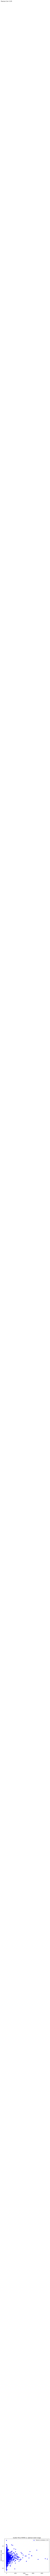

In [18]:
# Plot and visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(RPKM, Optimal_Codon_Usage, label=f'Pearson correlation: {corr:.2f}', color='b')
#plt.plot(RPKM, Optimal_Codon_Usage, color='r', linestyle='--')  # Add a line for better visualization

# Add labels and title
plt.xlabel('RPKM')
plt.ylabel('Optimal Codon Usage')
plt.title('Scatter Plot of RPKM vs. Optimal Codon Usage')

# Display the correlation on the plot
plt.text(0.5, 35, f'Pearson Corr: {corr:.2f}', fontsize=12, ha='center')

# Show the plot
plt.legend()
plt.show()